# Minecraft AI Build Generator

## Install Dependencies

In [ ]:
# uncomment to install the necessary libraries in Colab
!pip install --break-system-packages numpy pandas diffusers[training]==0.27.2 transformers==4.41.1 huggingface==0.0.1 huggingface-hub==0.23.1 ipywidgets==7.7.1 matplotlib==3.9.0 torchvision==0.18.0

Reshimming asdf python...


## Login

In [ ]:
import huggingface_hub

!git config --global credential.helper store
token = "" #@param {type:"string"}
huggingface_hub.login(token=token, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/randomgamingdev/.cache/huggingface/token
Login successful



## Training Configuration


In [ ]:
import torch
from dataclasses import dataclass

torch.set_default_device('cuda')
#torch.set_default_device('cpu')
device = torch.device("cuda")
#device = torch.device("cpu")

# arbitrary limit for each build dimension is 127
# over 95% of dimensions have dimensions less than 64%

@dataclass
class TrainingConfig:
    image_size = 64 # generated image res
    train_batch_size = 16 # was 16
    eval_batch_size = 16 # how many images to sample during evaluation (was 16)
    num_epochs = 200 # was 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 4
    save_image_epochs = 1 # was 10
    save_model_epochs = 1 # was 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "mcbuildgen"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = True  # whether the model repo is private in the HF Hub
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

## Load the dataset

/tmp/ipykernel_902442/1079141600.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


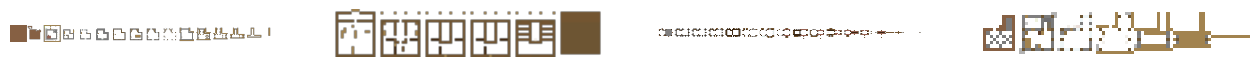

In [ ]:
import matplotlib.pyplot as plt
import datasets
from datasets import load_dataset, Features, Value
from PIL import Image

running_locally = True #@param {type:"boolean"}
local_dataset = "/home/randomgamingdev/Datasets/grabcraft-builds-png-slices-imgfolder" #@param {type:"string"}
remote_dataset = "/content/drive/MyDrive/Datasets/grabcraft-builds-png-slices-imgfolder" #@param {type:"string"}

config.dataset_name = local_dataset if running_locally else remote_dataset
if not running_locally:
  from google.colab import drive
  drive.mount("/content/drive")

features = Features({
    "file_name": Value('string'),
    "category": Value('string'),
    "group": Value('string'),
    "name": Value('string'),
    "dimensions": Value('string'),
    "tags": Value('string'),
})

dataset = load_dataset(config.dataset_name, delimiter=',', split="train", data_files={"train": "metadata.csv"}, column_names=["file_name", "category", "group", "name", "dimensions", "tags"], features=features)
def load_images(example):
    example["image"] = Image.open(f"{ config.dataset_name }/{ example['file_name'] }")
    return example
dataset = dataset.map(load_images)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## Load the Text and Tokenizer Models



In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

# Load tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

# Build transformations:

In [ ]:
import torch
from typing import Tuple, List
from torchvision.transforms import v2 as transforms, InterpolationMode
import torch.nn.functional as F

# Only the PIL image is passed in as of this moment
preprocess_to_tensor = transforms.Compose([
  #transforms.RandomHorizontalFlip(), # We don't care about any axis flips other than y
  transforms.RandomVerticalFlip(),
  transforms.ToImage(),
  transforms.ToDtype(torch.float32, scale=True),
  transforms.Normalize([0.5], [0.5]), # Normalizes the colors for the neural net's consumption
])

# Convert the tag list from a string to a list
def tag_str_to_list(tag_str):
    tag_list = tag_str.split("', '")
    tag_list[0] = tag_list[0][2:]
    tag_list[-1] = tag_list[-1][:-2]

    tag_list = tuple(tag_list)
    return tag_list

# Convert the dimensions to a tuple
def dims_str_to_tuple(dims_str):
  dims_list = dims_str.split(", ")
  dims_list[0] = dims_list[0][1:]
  dims_list[-1] = dims_list[-1][:-1]

  dims_list = tuple(int(s) for s in dims_list)
  return dims_list

def transform(item): # works for querying multiple
    # Pass in all the attributes (explicitly mention what we want and ignore the rest)
    transformed = {
        "images": [None for i in range(len(item["image"]))],
        "prompt": [f"{ item['category'][i] }, { item['group'][i] }, ({ item['dimensions'][i][1:-1] }), { item['name'][i] }, { item['tags'][i] }" for i in range(len(item["image"]))],
        #"category": item["category"],
        #"group": item["group"],
        #"name": item["name"],
        "dimensions": [dims_str_to_tuple(s) for s in item["dimensions"]],
        #"tags": [tag_str_to_list(s) for s in item["tags"]]
    }

    # Reshape to 3D
    for i in range(len(transformed["images"])):
      # For non-uniform
      dims_3d = dims_str_to_tuple(item["dimensions"][i])
      new_dims = dims_3d[1:2] + (4,) + dims_3d[0:1] + dims_3d[2:3]

      # Actual transformation
      transformed["images"][i] = preprocess_to_tensor(item["image"][i]).reshape((4,) + dims_3d).permute(2, 0, 1, 3)
      unpadded_shape = transformed["images"][i].shape

      # Resize
      transformed["images"][i] = F.interpolate(transformed["images"][i], size=(config.image_size, config.image_size), mode='nearest')

      # Pad with Zeroes
      padded_img = F.pad(input=transformed["images"][i], pad=(0, 0, 0, 0, 0, 0, 0, config.image_size - unpadded_shape[-4]), mode='constant', value=0)
      transformed["images"][i] = padded_img

    #print(transformed["prompt"])
    #print(item)

    return transformed

# Show image before transformation
#dataset[0]["image"].show()

# Set the transformation
dataset.set_transform(transform)

# Show a transformed layer
#transforms.ToPILImage()(dataset[0]["images"][0]).show()

for i in range(len(dataset)):
  size = dataset[i]["images"].shape
  if size != torch.Size([64, 4, 64, 64]):
    print(f"Invalid size of { size } detected!")
  #print(dataset[i]["prompt"])
  #transforms.ToPILImage()(dataset[0]["images"][2]).show()
  break

#def collate(batch):
  #print(len(batch))
  # Assuming each element in batch is a 3D tensor
  #return batch#torch.stack(batch, dim=0)

def collate(data: List[Tuple[torch.Tensor, torch.Tensor]]):
  #tensors, targets = zip(*data)
  #features = pad_sequence(tensors, batch_first=True)
  #targets = torch.stack(targets)
  return data

# Check for proper loading
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, generator=torch.Generator(device='cuda'), shuffle=False)#, collate_fn=collate)

for i, sample in enumerate(train_dataloader):
  size = sample["images"].shape
  if size != torch.Size([config.train_batch_size, 64, 4, 64, 64]):
    print(f"Atypical size of { size } detected!")
  #transforms.ToPILImage()(sample["images"][0][2]).show()
  break

## Create a UNet3DConditionModel

In [ ]:
import os

#from diffusers import UNet2DConditionModel
#
#model = UNet2DConditionModel(
#    sample_size=config.image_size, # the target image resolution (64)
#    in_channels=4,  # the number of input channels, 4 for RGBA images
#    out_channels=4,  # the number of output channels
#    layers_per_block=2,  # how many ResNet layers to use per UNet block
#    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
#    down_block_types=(
#        "DownBlock2D",
#        "DownBlock2D",
#        "DownBlock2D",
#        "DownBlock2D",
#        "AttnDownBlock2D",
#        "DownBlock2D",
#    ),
#    up_block_types=(
#        "UpBlock2D",
#        "AttnUpBlock2D",
#        "UpBlock2D",
#        "UpBlock2D",
#        "UpBlock2D",
#        "UpBlock2D",
#    ),
#    encoder_hid_dim=512
#)
#print(model.device)

from diffusers import UNet2DConditionModel
from huggingface_hub import HfFolder, Repository, whoami
from pathlib import Path

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

output_dir = "mcbuildgen" #@param {type:"string"}

# Get the repo
repo_name = get_full_repo_name(Path(output_dir).name)
repo = Repository(output_dir, clone_from=repo_name)

# Load the model
model = UNet2DConditionModel.from_pretrained("mcbuildgen/models/Model 0001/").cuda(); #0079

/home/randomgamingdev/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/home/randomgamingdev/mcbuildgen is already a clone of https://huggingface.co/RandomGamingDev/mcbuildgen. Make sure you pull the latest changes with `repo.git_pull()`.


It is often a good idea to quickly check the sample image shape matches the model output shape:

In [ ]:
import torch.nn as nn

print(f"Prompt: { dataset[0]['prompt'] }")
print(f"New Padded Dimensions: { dataset[0]['images'].shape }")

# Get the base layer of the item and make a batch of 1
sample_image = dataset[0]["images"][2].unsqueeze(0)
#transforms.ToPILImage()(sample_image[0]).show()
print(type(sample_image)) # This is now a tensor rather than an image
print("Input shape:", sample_image.shape) # Batch Size, Color Channels, Width, Depth

# Tokenize the text before entering it into the model
text = "A description of the image you want to generate"
inputs = tokenizer(text, return_tensors="pt")
text_embeddings = text_encoder(**inputs).last_hidden_state

print(f"Example Text Embeddings Shape: { text_embeddings.shape }")
print("Output shape:", model(sample_image, encoder_hidden_states=text_embeddings, timestep=0).sample.shape)

# encoder_hidden_states=(batch_size, sequence_length, hidden_size) and for timestep try 500 times till final result for now
# encoder_hidden_states=torch.zeros((sample_image.shape[0], 1, 1280))

Prompt: buildings, houses, (19, 16, 19), Medieval Puritan Trader's House, ['medieval', ' medieval house', 'trader', 'medieval trader', ' house']
New Padded Dimensions: torch.Size([64, 4, 64, 64])
<class 'torch.Tensor'>
Input shape: torch.Size([1, 4, 64, 64])
Example Text Embeddings Shape: torch.Size([1, 11, 512])
Output shape: torch.Size([1, 4, 64, 64])


## Add Noise

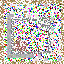

In [ ]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50]).cuda()
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# Display the whole thing
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps, encoder_hidden_states=text_embeddings).sample
loss = F.mse_loss(noise_pred, noise)

## Train the model

By now, you have most of the pieces to start training the model and all that's left is putting everything together.

First, you'll need an optimizer and a learning rate scheduler:

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

## Create the Pipeline

In [ ]:
import torch
from typing import Optional, Tuple, Union
from diffusers import DiffusionPipeline, ImagePipelineOutput
from diffusers import DDPMPipeline

torch.set_default_device('cuda')
device = torch.device("cuda")

class DDPMConditionPipeline(DDPMPipeline):
    def __init__(self, unet, scheduler, tokenizer, text_encoder):
        super().__init__(unet=unet, scheduler=scheduler)
        self.register_modules(tokenizer=tokenizer, text_encoder=text_encoder)

    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 1,
        generator: Optional[torch.Generator] = None,
        image: Optional[torch.FloatTensor] = None,
        prompt: str = "",
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        # Sample gaussian noise to begin loop
        if image is None:
            image = torch.randn(
                (batch_size, self.unet.in_channels, self.unet.sample_size, self.unet.sample_size),
                generator=generator,
            )
            image = image.to(self.device)

        # set step values
        self.scheduler.set_timesteps(1000)

        # Use the same prompt for each one
        text = [prompt for i in range(image.shape[0])]
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        text_embeddings = text_encoder(**inputs).last_hidden_state

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(image, t, encoder_hidden_states=text_embeddings).sample

            # 2. compute previous image: x_t -> t_t-1
            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

Then, you'll need a way to evaluate the model. For evaluation, you can use the [DDPMPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/ddpm#diffusers.DDPMPipeline) to generate a batch of sample images and save it as a grid:

In [ ]:
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGBA", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline, encoder_hidden_states=None):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.cuda.manual_seed(config.seed),
        #prompt="outdoors, other-190, (6, 9, 6), Oakshire Well, ['well', 'medieval town well', 'draw-well']"
        prompt="buildings, houses, (19, 16, 19), Medieval Puritan Trader's House, ['medieval', ' medieval house', 'trader', 'medieval trader', ' house']"
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

Now you can wrap all these components together in a training loop with 🤗 Accelerate for easy TensorBoard logging, gradient accumulation, and mixed precision training. To upload the model to the Hub, write a function to get your repository name and information and then push it to the Hub.

<Tip>

💡 The training loop below may look intimidating and long, but it'll be worth it later when you launch your training in just one line of code! If you can't wait and want to start generating images, feel free to copy and run the code below. You can always come back and examine the training loop more closely later, like when you're waiting for your model to finish training. 🤗

</Tip>

In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import torchvision.transforms as T
import os


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), position=0, leave=True, disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            # .select(1, 0) to start by generating the base layer
            clean_images = batch["images"].select(1, 0)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            # .select(1, 0).shape to get the base layer for now
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # Test
            #T.ToPILImage()(clean_images[0]).show()
            #T.ToPILImage()(noisy_images[0]).show()
            #return

            with accelerator.accumulate(model):
                # Predict the noise residual
                text = batch["prompt"]
                inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
                text_embeddings = text_encoder(**inputs).last_hidden_state

                noise_pred = model(noisy_images, timesteps, return_dict=False, encoder_hidden_states=text_embeddings)[0]
                # Checking against noise (matching against current image)
                loss = F.mse_loss(noise_pred, noise)
                # Checking against lower layer (matching against bottom image)
                # loss = F.mse_loss(noise_pred, noise)

                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # To generate following derived layers
            for i in range(1, config.image_size):
                # The layer we want to generate
                clean_images = batch["images"].select(1, i)
                bs = clean_images.shape[0]

                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
                ).long()

                # The layer below to generate based off of
                base_images = batch["images"].select(1, i - 1)

                with accelerator.accumulate(model):
                    # Predict the noise residual
                    text = batch["prompt"]
                    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
                    text_embeddings = text_encoder(**inputs).last_hidden_state

                    noise_pred = model(base_images, timesteps, return_dict=False, encoder_hidden_states=text_embeddings)[0]
                    # Checking against noise (matching against current image)
                    #loss = F.mse_loss(noise_pred, noise)
                    # Checking against lower layer (matching against bottom image)
                    loss = F.mse_loss(noise_pred, base_images - clean_images)

                    accelerator.backward(loss)

                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMConditionPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler, tokenizer=tokenizer, text_encoder=text_encoder)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, text_embeddings)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    # Try saving the model
                    model_dir = os.path.join(config.output_dir, "models")
                    os.makedirs(model_dir, exist_ok=True)
                    model.save_pretrained(f"{model_dir}/Model {epoch:04d}")

                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

Phew, that was quite a bit of code! But you're finally ready to launch the training with 🤗 Accelerate's [notebook_launcher](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher) function. Pass the function the training loop, all the training arguments, and the number of processes (you can change this value to the number of GPUs available to you) to use for training:

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/home/randomgamingdev/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/home/randomgamingdev/mcbuildgen is already a clone of https://huggingface.co/RandomGamingDev/mcbuildgen. Make sure you pull the latest changes with `repo.git_pull()`.


  0%|          | 0/435 [00:00<?, ?it/s]

/home/randomgamingdev/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)


Once training is complete, take a look at the final 🦋 images 🦋 generated by your diffusion model!

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])